In [13]:
import os
import pandas as pd
import numpy as np
import nltk
import re
import string 
import warnings
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from tabulate import tabulate
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as  plt 

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
# Set the environment variable OMP_NUM_THREADS to 1
os.environ["OMP_NUM_THREADS"] = "1"


In [2]:


def plot_speech(wordcloud):
    plt.figure(figsize=(8,8))
    plt.imshow(wordcloud)
    plt.axis("off");

file_path = r'C:\Users\pedam\Documents\src_data\kaggle_datasets\LibriSpeech\airline_sentiment_data\Tweets.csv'  

with open(file_path, 'r', encoding='utf-8') as file:
    speech = file.read()    

In [3]:
#Removing Irrelevant Words
# Replace with the actual path to your file
df_filecontent_tweets = pd.read_csv(file_path)
#print(tabulate(df_filecontents.head(), headers='keys', tablefmt='psql'))
df_filecontent_tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


In [4]:
df_filecontent_tweets.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


<Axes: xlabel='airline_sentiment', ylabel='count'>

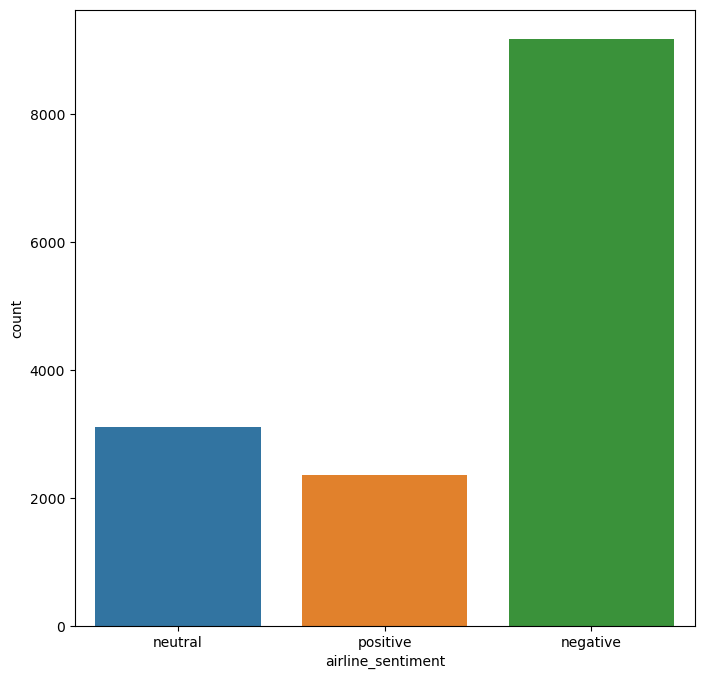

In [5]:
plt.figure(figsize=(8,8))
sns.countplot(x='airline_sentiment', data=df_filecontent_tweets)

In [6]:
#splitting the text and sentiment labels

text = df_filecontent_tweets.iloc[:, 1].values
text

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

In [7]:
sentiment = df_filecontent_tweets.iloc[:, 0].values
sentiment

array([570306133677760513, 570301130888122368, 570301083672813571, ...,
       569587242672398336, 569587188687634433, 569587140490866689],
      dtype=int64)

In [8]:
#Pre processing of the data

text_processed = []

for i in range(0, len(text)):
    #removing special characters
    text_extract = re.sub(r'\W',' ' ,str(text[i]))    
    #removing single words
    text_extract = re.sub(r'\s+[a-zA-Z]\s+', ' ', text_extract)
    #removing single characters from the beginning
    text_extract = re.sub(r'\^[a-zA-Z]\s+',' ', text_extract)
    #Removing white space
    text_extract = re.sub(r'\s+', ' ',  text_extract, flags = re.I)
    #removing extra prefixed character 'b' from the text
    text_extract = re.sub(r'^b\s+', '',  text_extract)
    #Converting the text to lowercase
    text_extract = text_extract.lower()
    
    text_processed.append(text_extract)
    

In [9]:
text_processed

['neutral',
 'positive',
 'neutral',
 'negative',
 'negative',
 'negative',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'positive',
 'negative',
 'positive',
 'positive',
 'negative',
 'positive',
 'positive',
 'neutral',
 'negative',
 'negative',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'neutral',
 'negative',
 'negative',
 'positive',
 'neutral',
 'positive',
 'positive',
 'neutral',
 'negative',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'neutral',
 'neutral',
 'positive',
 'neutral',
 'negative',
 'negative',
 'positive',
 'negative',
 'neutral',
 'neutral',
 'neutral',
 'negative',
 'positive',
 'positive',
 'neutral',
 'neutral',
 'negative',
 'ne

In [16]:
#Stemming and Bag of Words
from nltk.corpus import stopwords
# nltk.download('stopwords')
# import nltk.stem
stemming = SnowballStemmer('english')

class Stemming(TfidfVectorizer):
    def build_analyzer(self):
        textanalyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda tweetdoc: (stemming.stem(i) for i in textanalyzer(tweetdoc))



In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import nltk

# Sample text data
text_processed = ["This is an example sentence.", "Another example sentence."]

# Initialize SnowballStemmer
stemming = SnowballStemmer('english')

# Define a custom tokenizer function that includes stemming
def custom_tokenizer(text):
    tokens = nltk.word_tokenize(text)
    stems = [stemming.stem(token) for token in tokens]
    return stems

# Initialize TfidfVectorizer with custom tokenizer and adjusted parameters
textvectorizer = TfidfVectorizer(
    max_features=2500,
    min_df=1,  # Adjust according to your needs
    max_df=0.8,  # Adjust according to your needs, should be higher than min_df
    stop_words=stopwords.words('english'),
    tokenizer=custom_tokenizer
)

# Fit and transform the text data
text_processed_vectorized = textvectorizer.fit_transform(text_processed).toarray()

# Get the feature names (words)
words = textvectorizer.get_feature_names_out()

# Print the total number of words
print("Total number of words:", len(words))



Total number of words: 1


In [24]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Example text
example_text = "The quick brown foxes are jumping over the lazy dogs"

# Tokenize the text
words = word_tokenize(example_text)

# Initialize SnowballStemmer
stemming = SnowballStemmer('english')

# Perform stemming on each word
stemmed_words = [stemming.stem(word) for word in words]

# Print the original words and their stemmed counterparts
print(f"Original words: {words}")
print(f"Stemmed words: {stemmed_words}")


Original words: ['The', 'quick', 'brown', 'foxes', 'are', 'jumping', 'over', 'the', 'lazy', 'dogs']
Stemmed words: ['the', 'quick', 'brown', 'fox', 'are', 'jump', 'over', 'the', 'lazi', 'dog']


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pedam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
